Chapter 8

8-1 합성곱 연산

In [1]:
#넘파이 배열 정의하고 배열 하나 선택해 뒤집기
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [2]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [3]:
w_r = w[::-1]
print(w_r)

[3 5 1 2]


In [4]:
#넘파이의 점 곱으로 합성곱 수행
for i in range(6):
  print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [5]:
#싸이파이로 합성곱 수행
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [6]:
#valid padding
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [7]:
#full padding
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [8]:
#same padding
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [9]:
x = np.array([[1, 2, 3],
              [4, 5, 6,],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])
from scipy.signal import correlate2d
#valid padding
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [10]:
#same padding
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [11]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

<ipython-input-11-b5fc619af11d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_4d = x.astype(np.float).reshape(1, 3, 3, 1)


In [12]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

In [13]:
c_out.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

8-2 풀링 연산

In [14]:
x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12,],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

In [15]:
#max pooling
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

8-3 합성곱 신경망 구조

In [16]:
#렐루 함수 구현
def relu(x):
  return np.maximum(x, 0)

In [17]:
x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

In [18]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

8-4 합성곱 신경망을 만들고 훈련

In [19]:
#합성곱 신경망
class ConvolutionNetwork:

    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels    #합성곱의 커널 개수
        self.kernel_size = 3          #커널 크기
        self.optimizer = None         #옵티마이저
        self.conv_w = None            #합성곱 층의 가중치
        self.conv_b = None            #합성곱 층의 절편
        self.units = units            #은닉층의 뉴런 개수
        self.batch_size = batch_size  #배치 크기
        self.w1 = None                #은닉층의 가중치
        self.b1 = None                #은닉층의 절편
        self.w2 = None                #출력층의 가중치
        self.b2 = None                #출력층의 절편
        self.a1 = None                #은닉층의 활성화 출력
        self.losses = []              #훈련 손실
        self.val_losses = []          #검증 손실
        self.lr = learning_rate       #학습률

    def forpass(self, x):
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b #3x3 합성곱 연산을 수행
        r_out = tf.nn.relu(c_out) #렐루 활성화 함수를 적용
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID') #2x2 max pooling을 적용
        f_out = tf.reshape(p_out, [x.shape[0], -1])  #첫 번째 배치 차원을 제외하고 출력을 일렬로 펼cla
        z1 = tf.matmul(f_out, self.w1) + self.b1     #첫 번째 층의 선형 식을 계산
        a1 = tf.nn.relu(z1)                          #활성화 함수를 적용
        z2 = tf.matmul(a1, self.w2) + self.b2        #두 번째 층의 선형 식을 계산
        return z2

    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          #(특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    #은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           #(은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     #클래스 개수

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    #은닉층과 출력층의 가중치를 초기화
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        for i in range(epochs): #epochs만큼 반복
            print('에포크', i, end=' ')
            batch_losses = [] #제너레이터 함수에서 반환한 미니배치를 순환
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch)) #배치 손실을 기록
            print()
            self.losses.append(np.mean(batch_losses)) #배치 손실 평균내어 훈련 손실 값으로 저장
            self.val_losses.append(self.get_loss(x_val, y_val)) #검증 세트에 대한 손실을 계산

    def gen_batch(self, x, y): #미니배치 제너레이터 함수
        bins = len(x) // self.batch_size                   #미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) #인덱스 섞기
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   #batch_size만큼 슬라이싱하여 반환

    def training(self, x, y):
        m = len(x)                    #샘플 개수를 저장
        with tf.GradientTape() as tape:
            z = self.forpass(x)       #정방향 계산을 수행
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z) #손실을 계산
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        grads = tape.gradient(loss, weights_list) #가중치에 대한 그래디언트를 계산
        self.optimizer.apply_gradients(zip(grads, weights_list)) #가중치를 업데이트

    def predict(self, x):
        z = self.forpass(x)                 #정방향 계산을 수행
        return np.argmax(z.numpy(), axis=1) #가장 큰 값의 인덱스를 반환

    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1)) #예측과 타깃 열 벡터를 비교하여 True의 비율을 반환

    def get_loss(self, x, y):
        z = self.forpass(x)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [20]:
#합성곱 신경망 훈련
#데이터 세트 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [21]:
#훈련 데이터 세트를 훈련 세트와 검증 세트로 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2,
                                                  random_state=42)

In [22]:
#타깃을 원-핫 인코딩으로 변환
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [23]:
#입력 데이터 준비
x_train = x_train.reshape(-1 ,28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [24]:
x_train.shape

(48000, 28, 28, 1)

In [25]:
#입력 데이터 표준화 전처리
x_train = x_train / 255
x_val = x_val / 255

In [26]:
#모델 훈련
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


에포크 0 .

......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 .............................................................................................................................................................................................................................................

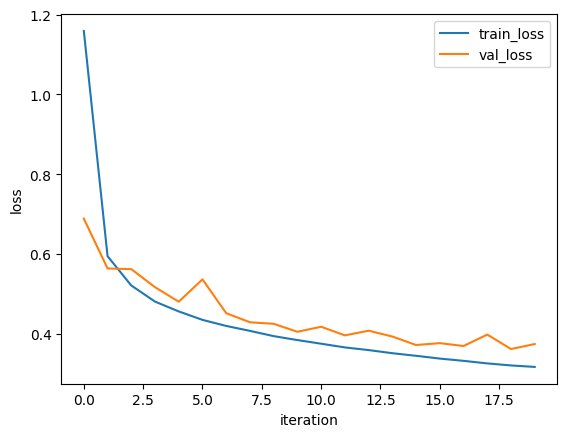

In [27]:
#훈련, 검증 손실 그래프
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [28]:
 #검증 세트 정확도 확인
 cn.score(x_val, y_val_encoded)

0.86775

8-5 케라스로 합성곱 신경망 생성

In [29]:
#필요한 클래스들을 임포트
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [30]:
#합성곱층 쌓기
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))

In [31]:
#풀링층 쌓기
conv1.add(MaxPooling2D((2, 2)))

In [32]:
#완전 연결층에 주입할 수 있도록 특성 맵 펼치기
conv1.add(Flatten())

In [33]:
#완전 연결층 쌓기
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [34]:
#모델 구조 확인
conv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 100)               196100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
__________________________________________________

In [35]:
#합성공 신경망 모델 훈련
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
#아담 옵티마이저 사용하기
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4444 - accuracy: 0.8438 - val_loss: 0.3423 - val_accuracy: 0.8750
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3003 - accuracy: 0.8910 - val_loss: 0.2886 - val_accuracy: 0.8952
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2536 - accuracy: 0.9062 - val_loss: 0.2795 - val_accuracy: 0.9030
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2237 - accuracy: 0.9179 - val_loss: 0.2525 - val_accuracy: 0.9102
Epoch 5/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2006 - accuracy: 0.9261 - val_loss: 0.2514 - val_accuracy: 0.9099
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1787 - accuracy: 0.9335 - val_loss: 0.2748 - val_accuracy: 0.9005
Epoch 7/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1625 - accuracy: 0.9401 - val_loss: 0.2456 - val_accuracy:

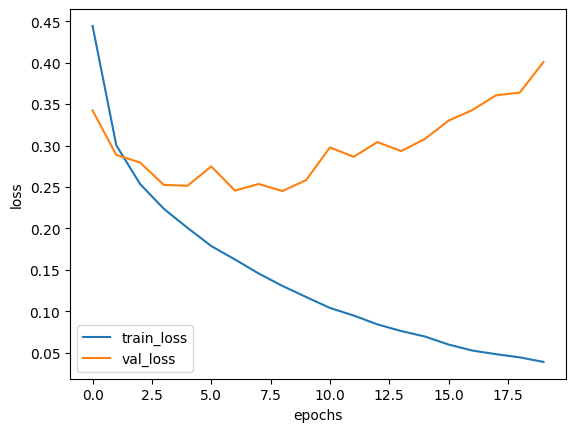

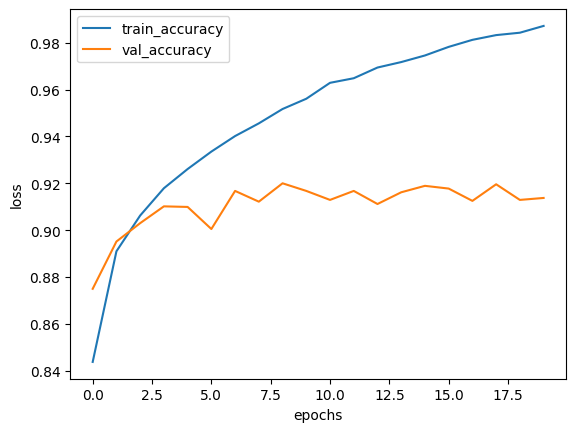

In [37]:
#손실 그래프와 정확도 그래프 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [38]:
#드롭아웃을 적용해 합성곱 신경망 구현
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [39]:
#드롭아웃층 확인
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1960)              0         
                                                                 
 dropout (Dropout)           (None, 1960)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               196100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                      

In [40]:
#훈련하기
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5026 - accuracy: 0.8226 - val_loss: 0.3428 - val_accuracy: 0.8784
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3668 - accuracy: 0.8680 - val_loss: 0.3090 - val_accuracy: 0.8896
Epoch 3/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3315 - accuracy: 0.8784 - val_loss: 0.2826 - val_accuracy: 0.8975
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3013 - accuracy: 0.8873 - val_loss: 0.2622 - val_accuracy: 0.9041
Epoch 5/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2849 - accuracy: 0.8945 - val_loss: 0.2491 - val_accuracy: 0.9102
Epoch 6/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2677 - accuracy: 0.8997 - val_loss: 0.2468 - val_accuracy: 0.9100
Epoch 7/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2563 - accuracy: 0.9037 - val_loss: 0.2400 - val_accurac

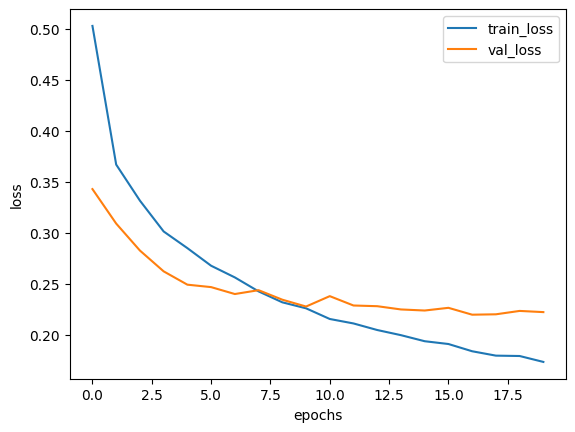

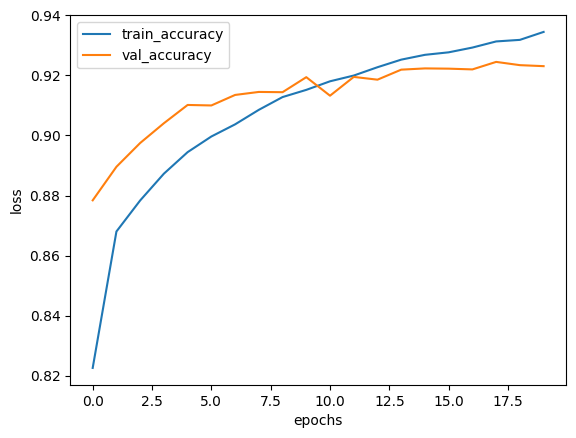

In [41]:
#손실 그래프와 정확도 그래프 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()